## __Objective:__ Create a multiclass image classifier

## __Purpose:__ Can be used to classify  species of animal

### Use transfer learning and vgg16 model

### importing necessary libraries

In [10]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
 
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math  
import datetime
import time

Loading up our image datasets

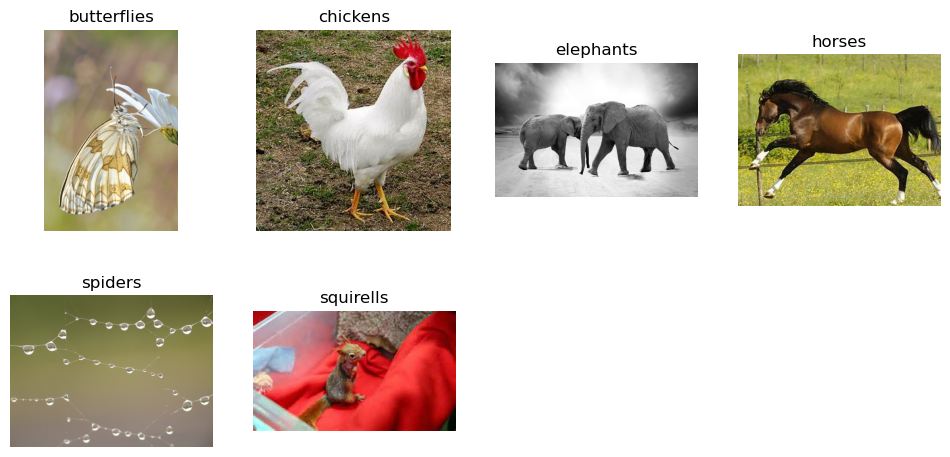

In [11]:
# Let's plot a few images
train_path = "data/train"
validation_path = "data/validation"
test_path = "data/test"
import os, shutil
image_categories = os.listdir('data/train')

def plot_images(image_categories):
    
    # Create a figure
    plt.figure(figsize=(12, 12))
    for i, cat in enumerate(image_categories):
        
        # Load images for the ith category
        image_path = train_path + '/' + cat
        images_in_folder = os.listdir(image_path)
        first_image_of_folder = images_in_folder[0]
        first_image_path = image_path + '/' + first_image_of_folder
        img = image.load_img(first_image_path)
        img_arr = image.img_to_array(img)/255.0
        
        
        # Create Subplot and plot the images
        plt.subplot(4, 4, i+1)
        plt.imshow(img_arr)
        plt.title(cat)
        plt.axis('off')
        
    plt.show()

# Call the function
plot_images(image_categories)

In [12]:
#Default dimensions we found online
img_width, img_height = 224, 224  
   
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5' 

# loading up our datasets
train_data_dir = 'data/train'  
validation_data_dir = 'data/validation'  
test_data_dir = 'data/test'
   
# number of epochs to train top model  
epochs = 7 #this has been changed after multiple model run  
# batch size used by flow_from_directory and predict_generator  
batch_size = 50  

In [13]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet') 

In [14]:
datagen = ImageDataGenerator(rescale=1. / 255)  #needed to create the bottleneck .npy files

# Creation of weights/features with VGG16

In [9]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)  
   
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 13412 images belonging to 6 classes.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1520\2973591495.py:18: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)


Time:  0:15:28.444214


In [10]:
print('-'*117)

---------------------------------------------------------------------------------------------------------------------


In [11]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 2549 images belonging to 6 classes.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1520\2798664618.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_validation = vgg16.predict_generator(


Time:  0:02:59.613353


In [12]:
print('-'*117)

---------------------------------------------------------------------------------------------------------------------


In [13]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgg16.predict_generator(  
     generator, predict_size_test)  
   
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1845 images belonging to 6 classes.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1520\143667794.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_test = vgg16.predict_generator(


Time:  0:02:10.163521


# Loading training, validation and testing data

In [15]:
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 13412 images belonging to 6 classes.


In [16]:
#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 2549 images belonging to 6 classes.


In [17]:
#testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 1845 images belonging to 6 classes.


# Training of model

In [18]:
#This is the best model we found. For additional models, check out I_notebook.ipynb
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=7,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Epoch 1/7



269/269 [==============================] - 5s 15ms/step - loss: 1.2767 - acc: 0.6816 - val_loss: 0.4592 - val_acc: 0.8592
Epoch 2/7
269/269 [==============================] - 3s 13ms/step - loss: 0.6713 - acc: 0.8149 - val_loss: 0.3591 - val_acc: 0.8902
Epoch 3/7
269/269 [==============================] - 3s 13ms/step - loss: 0.4959 - acc: 0.8583 - val_loss: 0.8164 - val_acc: 0.7893
Epoch 4/7
269/269 [==============================] - 3s 12ms/step - loss: 0.3993 - acc: 0.8803 - val_loss: 0.4053 - val_acc: 0.8831
Epoch 5/7
269/269 [==============================] - 3s 12ms/step - loss: 0.3162 - acc: 0.9023 - val_loss: 0.4603 - val_acc: 0.8717
Epoch 6/7
269/269 [==============================] - 3s 12ms/step - loss: 0.2903 - acc: 0.9102 - val_loss: 0.2778 - val_acc: 0.9125
Epoch 7/7
51/51 [==============================] - 0s 5ms/step - loss: 0.5385 - acc: 0.8690
[INFO] accuracy: 86.90%
[INFO] Loss: 0.5384920239448547
Time:  0:00:26.072905


In [19]:
#Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 100)               2508900   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 306       
                                                                 
Total params: 2514256 (9.59 MB)
Trainable params: 251425

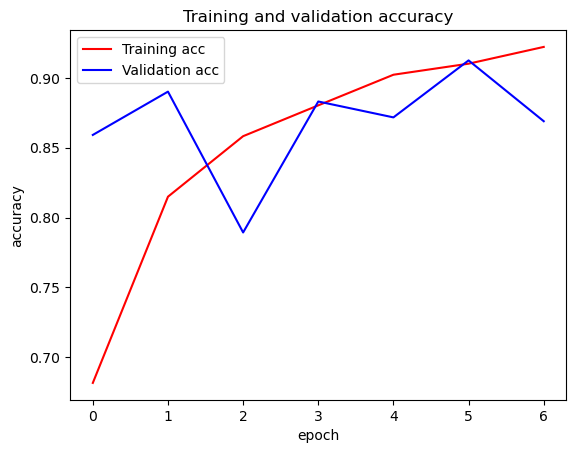

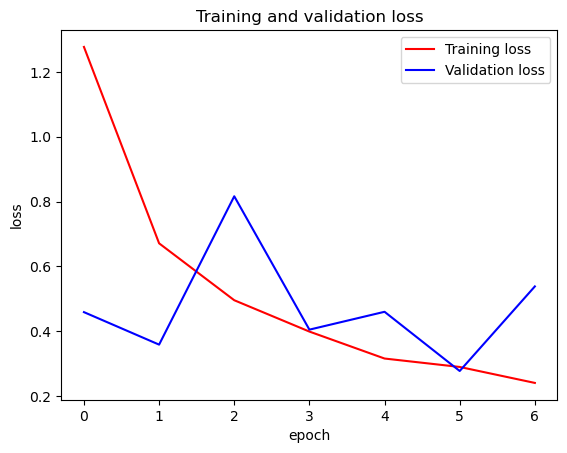

In [20]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

## Model Evaluation on Testing Set

In [21]:
model.evaluate(test_data, test_labels)

58/58 [==============================] - 0s 4ms/step - loss: 0.3677 - acc: 0.9046


[0.3676501214504242, 0.9046070575714111]

## Classification metrics and Confusion Matrix

### Classification Metrics

In [22]:
print('test data', test_data)
preds = np.round(model.predict(test_data),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[1.62910104e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.54943490e-01 0.00000000e+00]
   [9.73951742e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    6.17594421e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    4.81749952e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    4.90739822e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    4.19955671e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    5.68091273e-01 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    5.71550012e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 2.10542679e-01 ... 0.00000000e+00
    3.51710856e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 6.56101167e-01 ... 0.00000000e+00
    1.31017268e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 4.20266509e-0

In [23]:
animals = ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=animals )
print(classification_metrics)

              precision    recall  f1-score   support

 butterflies       0.93      0.95      0.94       371
    chickens       0.69      0.96      0.80       203
   elephants       0.94      0.86      0.89       152
      horses       0.94      0.97      0.96       472
     spiders       0.97      0.87      0.91       403
   squirells       0.98      0.73      0.83       244

   micro avg       0.91      0.90      0.91      1845
   macro avg       0.91      0.89      0.89      1845
weighted avg       0.92      0.90      0.91      1845
 samples avg       0.90      0.90      0.90      1845



C:\Users\DELL\anaconda3\envs\rr_tfd\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion Matrix

In [24]:
#Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
# label of the maximum value thus creating a categorical variable
#Basically, flipping a dummy variable back to it's categorical variable
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [25]:
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

C:\Users\DELL\anaconda3\envs\rr_tfd\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\DELL\anaconda3\envs\rr_tfd\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\DELL\anaconda3\envs\rr_tfd\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\DELL\anaconda3\envs\rr_tfd\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_

In [26]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization


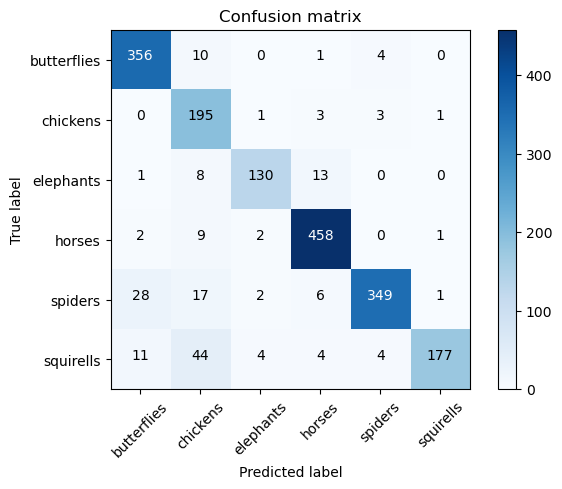

In [27]:
plot_confusion_matrix(confusion_matrix, ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells'])

Normalized confusion matrix


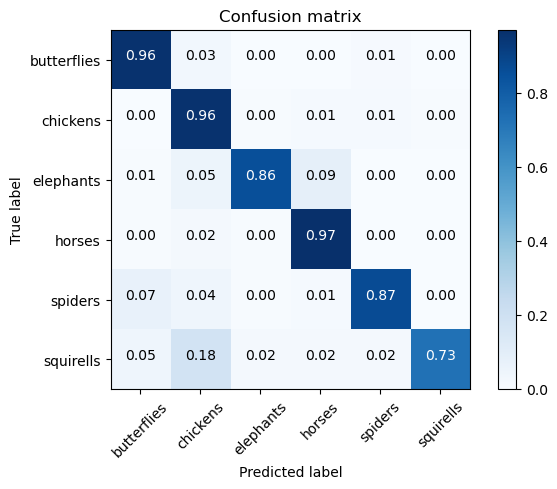

In [28]:
#Those numbers are all over the place. Now turning normalize= True
plot_confusion_matrix(confusion_matrix, 
                      ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells'],
                     normalize=True)

## Testing images on model

In [29]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

In [30]:
def test_single_image(path):
    animals = ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)  
    preds = model.predict(bt_prediction)
    for idx, animal, x in zip(range(0,6), animals , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    class_predicted = model.predict(bt_prediction)
    classes = np.argmax(class_predicted, axis=1)
    class_dictionary = generator_top.class_indices  
    inv_map = {v: k for k, v in class_dictionary.items()}  
    print("ID: {}, Label: {}".format(class_predicted[0], inv_map[classes[0]]))  
    return load_img(path)

In [31]:
path = 'data/test/bu.jpg'

[INFO] loading and preprocessing image...
1/1 [==============================] - 0s 71ms/step
ID: 0, Label: butterflies 100.0%
ID: 1, Label: chickens 0.0%
ID: 2, Label: elephants 0.0%
ID: 3, Label: horses 0.0%
ID: 4, Label: spiders 0.0%
ID: 5, Label: squirells 0.0%
Final Decision:
.
..
...
1/1 [==============================] - 0s 25ms/step
ID: [1.0000000e+00 2.6714609e-20 4.0261269e-27 3.8916623e-24 9.6168657e-13
 5.7065912e-25], Label: butterflies


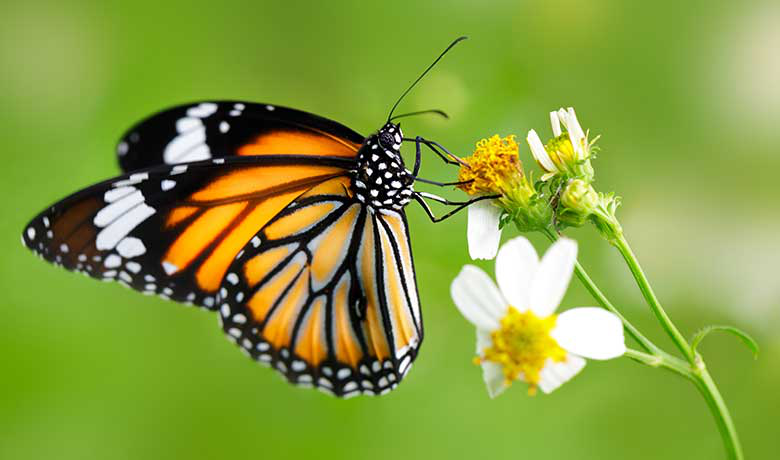

In [32]:
test_single_image(path)

In [33]:
%%capture
# Model Accuracy
x1 = model.evaluate(train_data,train_labels)
x2 = model.evaluate(validation_data, validation_labels)
x3 = model.evaluate(test_data,test_labels)

In [34]:
print('Training Accuracy  : %1.2f%%     Training loss  : %1.6f'%(x1[1]*100,x1[0]))
print('Validation Accuracy: %1.2f%%     Validation loss: %1.6f'%(x2[1]*100,x2[0]))
print('Test Accuracy: %1.2f%%     Test loss: %1.6f'%(x3[1]*100,x3[0]))

Training Accuracy  : 93.98%     Training loss  : 0.164322
Validation Accuracy: 86.90%     Validation loss: 0.538492
Test Accuracy: 90.46%     Test loss: 0.367650


In [47]:
predictions = model.predict(test_data)

58/58 [==============================] - 0s 4ms/step


In [87]:
test_dataset = 'data/test'
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 target_size=(img_width, img_height),  
                                                 batch_size=batch_size, 
                                                 
                                                 class_mode='categorical')

Found 1845 images belonging to 6 classes.


58/58 [==============================] - 0s 2ms/step
Label Mappings for classes present in the training and validation datasets

0 : butterflies
1 : chickens
2 : elephants
3 : horses
4 : spiders
5 : squirells


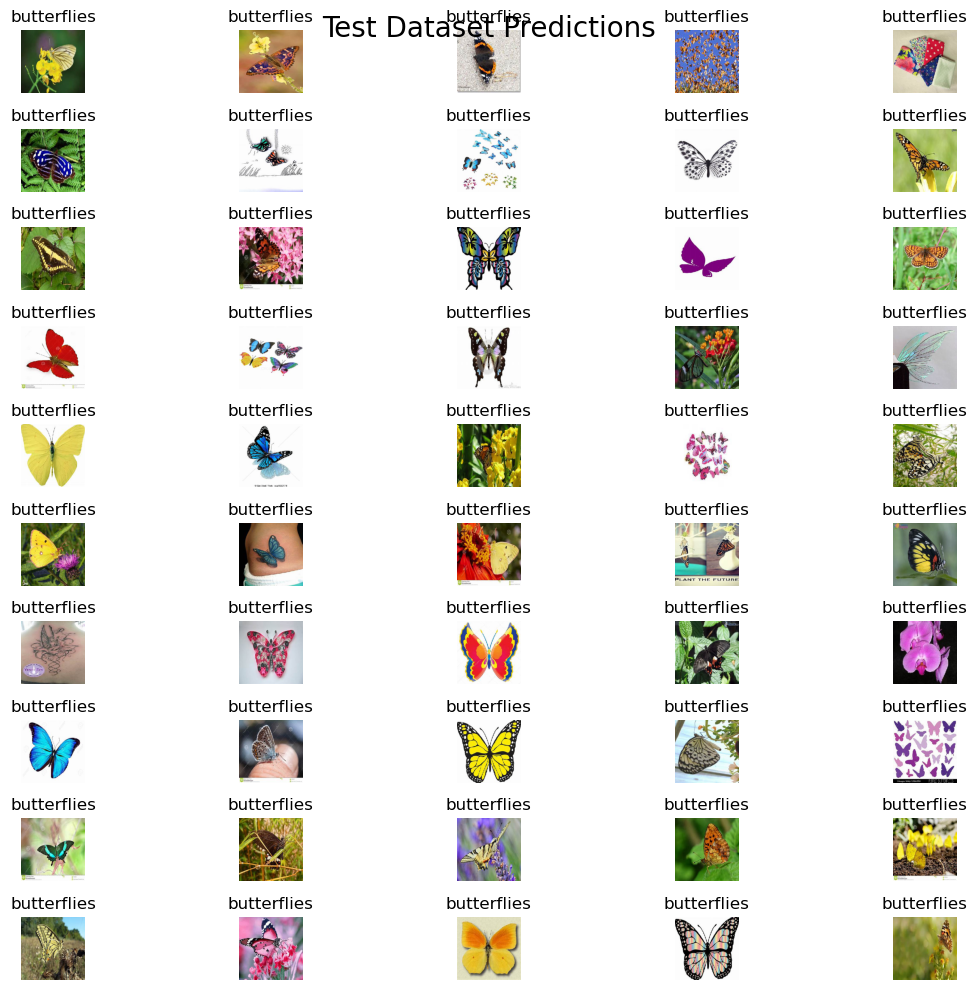

In [109]:
predictions = model.predict(test_data)
fig, ax = plt.subplots(nrows=10, ncols=5, figsize=(12, 10))
idx = 0
labels = {value: key for key, value in test_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")

for key, value in labels.items():
    print(f"{key} : {value}")
for i in range(10):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [116]:
test_dataset_dir = 'data/test/test_images'
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_dataset_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgg16.predict_generator(  
     generator, predict_size_test)  
   
np.save('bottleneck_features_test2.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 62 images belonging to 6 classes.


C:\Users\DELL\AppData\Local\Temp\ipykernel_9976\119431993.py:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_test = vgg16.predict_generator(


Time:  0:00:02.734435


In [117]:
#testing data
generator_top = datagen.flow_from_directory(  
         test_dataset_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test2.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 62 images belonging to 6 classes.


2/2 [==============================] - 0s 5ms/step
Label Mappings for classes present in the training and validation datasets

0 : butterflies
1 : chickens
2 : elephants
3 : horses
4 : spiders
5 : squirells


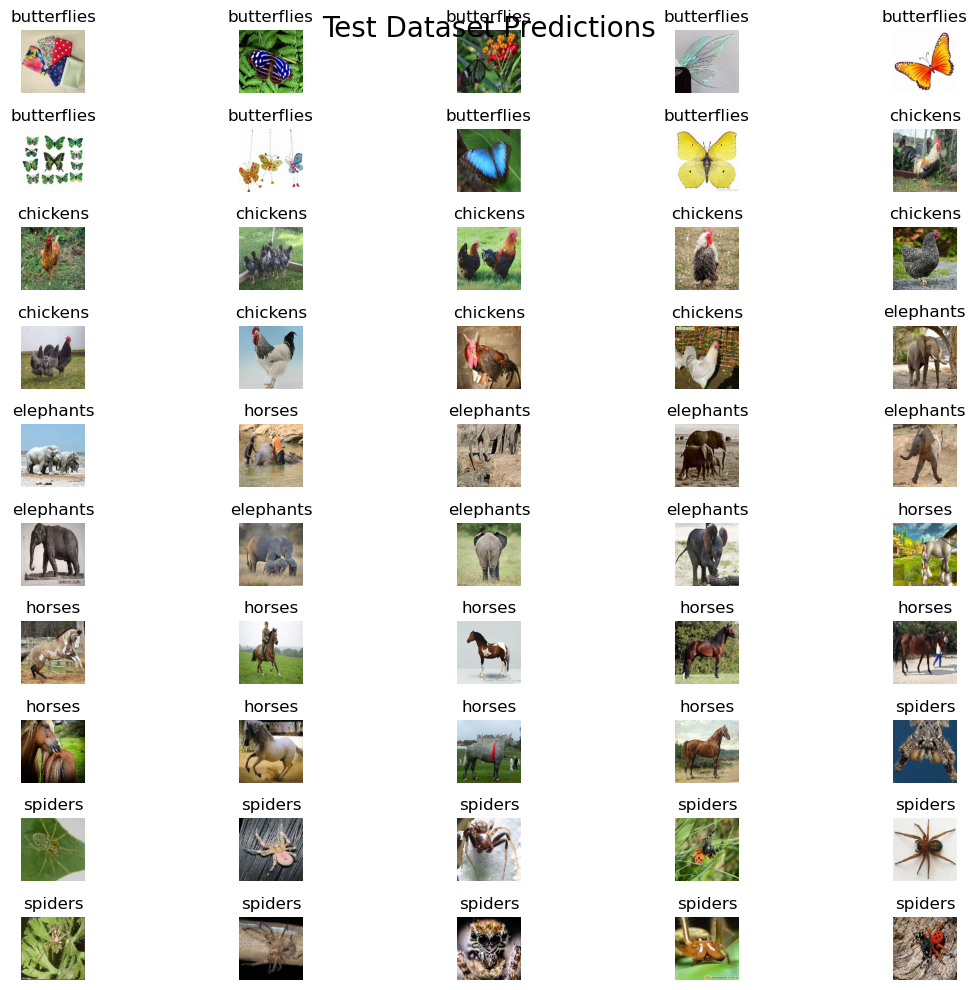

In [133]:
predictions = model.predict(test_data)
fig, ax = plt.subplots(nrows=10, ncols=5, figsize=(12, 10))
idx = 0
labels = {value: key for key, value in test_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")

for key, value in labels.items():
    print(f"{key} : {value}")
for i in range(10):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions\n\n\n", fontsize=20)
plt.show()

In [120]:
x3 = model.evaluate(test_data,test_labels)
print('New Test Accuracy: %1.2f%%     Test loss: %1.6f'%(x3[1]*100,x3[0]))

2/2 [==============================] - 0s 4ms/step - loss: 0.4473 - acc: 0.9194
New Test Accuracy: 91.94%     Test loss: 0.447303
